In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import quandl as ql
import statsmodels.formula.api as smf
pd.set_option('display.float_format', lambda x: '%.9f' % x)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
ql.ApiConfig.api_key = os.getenv('QUANDL_API_KEY')

 # Return Forecasting:  Read Historical Daily Yen Futures Data from Quandl

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
fut = ql.get("CHRIS/CME_JY1", start_date="1990-01-01", end_date="2019-10-7")
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


 # Return Forecasting: Initial Time-Series Plotting

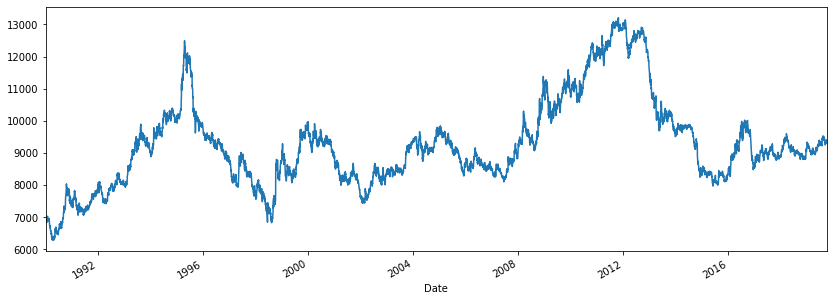

In [4]:
fut['Settle'].plot(figsize=(14,5))

 # Return Forecasting: MA/EWMA Smoothing of Futures Prices

 1. Plot the Settle Price, along with a moving average of 15 and 60 days. Use indexing to just plot the data from 2015 onward.
 2. What do you see now, in terms of short versus long-term trends?
 3. Try an exponential moving average, with a half life of 15 days.
 4. Which seems to respond faster, an exponential moving average with a half life of 15 days, or a moving average of 15 days?

 (15 days = 3 weeks)
 (60 days = 3 months)

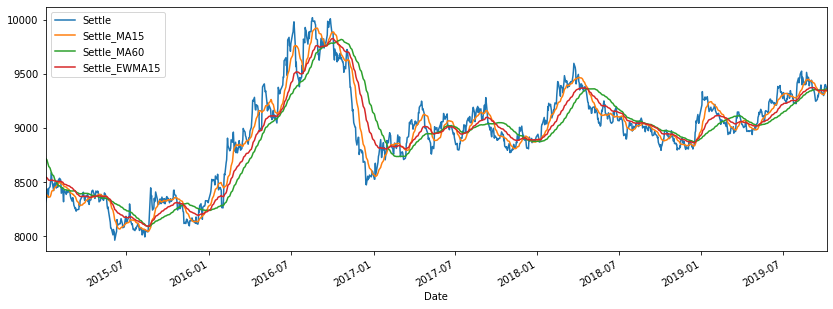

In [5]:
# Moving averages and exponentially weighted moving averages

df=fut[["Settle"]].copy()
df['Settle_MA15']= df.Settle.rolling(window=15).mean()
df['Settle_MA60']= df.Settle.rolling(window=60).mean()
df['Settle_EWMA15']= df.Settle.ewm(halflife=15).mean()

df["2015":].plot(figsize=(14,5))

# Return Forecasting: Decomposition Using a Hodrick-Prescott Filter

In [6]:
import statsmodels.api as sm

ts_noise, ts_trend = sm.tsa.filters.hpfilter(df['Settle'])

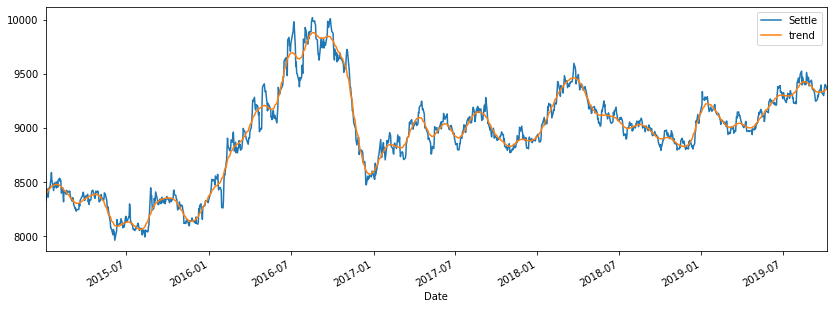

In [7]:
futures_decomp = df[["Settle"]].copy()

futures_decomp["trend"] = ts_trend
futures_decomp.head()

futures_decomp["2015":].plot(figsize=(14,5))


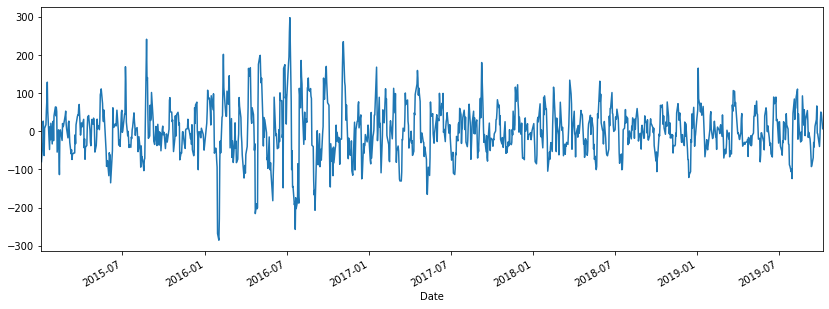

In [8]:
ts_noise["2015":].plot(figsize=(14,5))

 # Return Forecasting: Seasonal Effects with Sklearn Linear Regression
 Using the full dataset, use a SKLearn linear regression to predict Yen futures ("settle") returns with *lagged* Yen futures returns and categorical calendar seasonal effects (e.g., day-of-week or week-of-year seasonal effects).


In [9]:
#Using the dataframe containing "Settle" Prices:
fut.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-01,9298.500000000,9336.500000000,9264.500000000,9327.500000000,30.500000000,9328.500000000,151138.000000000,145022.000000000
2019-10-02,9325.000000000,9388.000000000,9313.500000000,9373.500000000,45.000000000,9373.500000000,141562.000000000,147082.000000000
2019-10-03,9377.000000000,9434.000000000,9362.500000000,9396.000000000,24.000000000,9397.500000000,160927.000000000,141349.000000000
2019-10-04,9398.500000000,9446.500000000,9376.500000000,9394.500000000,2.000000000,9399.500000000,121572.000000000,140800.000000000
2019-10-07,9417.000000000,9417.500000000,9345.000000000,9364.500000000,39.000000000,9360.500000000,96834.000000000,145171.000000000


In [10]:
from sklearn.linear_model import LinearRegression

# Construct a "Futures Return" column, using pandas pct_change() on the "Settle" price 
fut["future_return"] = fut["Settle"].copy().pct_change()*100

# Feature Engineering
# Created a second "Lagged Return" variable, that is the futures return variable shifted above, but lagged 1 day:
# We"ll use this lagged return as the feature vector X:
fut["lagged_return"] = fut["Settle"].shift().pct_change()*100
fut = fut.replace(-np.inf, np.nan).dropna()

# Construct a new "X" dataframe using just the "Lagged Return" variable:
X = fut["lagged_return"].to_frame()

In [11]:
# Added into the X dataframe a "weekofyear" column using X.index.weekofyear 
X["Week_of_year"] = X.index.weekofyear

# Create a new categorical X dataframe, by using pd.get_dummies() on the seasonal column created just above:
X_binary_encoded = pd.get_dummies(X, columns=['Week_of_year']) 
X_binary_encoded.head()

,lagged_return,Week_of_year_1,Week_of_year_2,Week_of_year_3,Week_of_year_4,Week_of_year_5,Week_of_year_6,Week_of_year_7,Week_of_year_8,Week_of_year_9,...,Week_of_year_44,Week_of_year_45,Week_of_year_46,Week_of_year_47,Week_of_year_48,Week_of_year_49,Week_of_year_50,Week_of_year_51,Week_of_year_52,Week_of_year_53
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-18,0.409123453,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-19,-0.427829276,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-20,-0.020460358,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,0.020464545,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,-0.204603581,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Create a "y" series, using just the "Futures Return" column created above.
y = fut["future_return"].copy()

# Construct a "LinearRegression" object:
model = LinearRegression()

# Fit a model using the X and y objects:
results = model.fit(X_binary_encoded, y)
results

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
# Construct predictions based on the X object:
predictions = model.predict(X_binary_encoded)
predictions

array([-0.09301758, -0.05368042, -0.07284546, ..., -0.06265259,
       -0.05200195,  0.09188843])

 Summarize the quality of your model using R2 and root-mean-squared-error (RMSE) statistics. How good is it?

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)

In [15]:
# Calculate mean squared error 
# Remember, a "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.
mse = mean_squared_error(y, predictions)

In [16]:
# Using mean squared eror above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

In [17]:
# Print the r2, mser, rmse, and standard deviation
print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {np.std(y)}")

R-squared (R2 ): 0.0493297191785943
Mean Squared Error (MSE): 0.28350476722765017
Root Mean Squared Error (RMSE): 0.5324516571742923
Standard Deviation of Futures Return: 0.5460912580268747


 #### Plotting and Independent (X) Variable Interpretation

 Plot the model predictions of returns against actual returns, for just data from 2018 onward.

In [18]:
# Create a "y" dataframe, using just the "Futures Return" column created above. 
y_df = y.to_frame()

# Add the model predictions from above as an additional column to that dataframe:
y_df['predictions'] = predictions
y_df.head()

,future_return,predictions
Date,,
2014-02-18,-0.427829276,-0.093017578
2014-02-19,-0.020460358,-0.053680420
2014-02-20,0.020464545,-0.072845459
2014-02-21,-0.204603581,-0.074768066
2014-02-24,0.020502307,-0.066070557


 Separately, plot the calendar effects estimated from the model using matplotlib. Do you see any seasonal patterns?

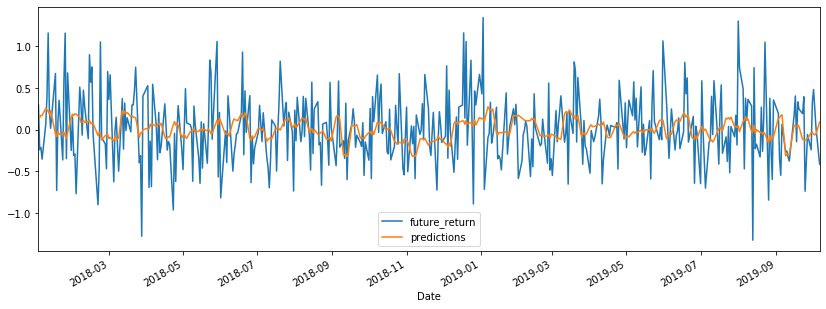

In [19]:
#Plotting predictions vs actual returns 2018 onward.
y_df["2018":].plot(figsize=(14,5))

In [20]:
# Construct a dataframe of the model calendar-effect coefficients and review the output:
results = pd.DataFrame(model.coef_, columns=["Coefficient"], index=X_binary_encoded.columns)

# Filter results so that it only includes either the day-of-week or week-of-year effect 
results = (results[results.index.str.contains("Week_of_year")])

results.head(10) #these values are too high, could not found out why, ence the bar plot will be useless with this data.

,Coefficient
Week_of_year_1,-184744367323.116638184
Week_of_year_2,-184744367323.035430908
Week_of_year_3,-184744367323.327606201
Week_of_year_4,-184744367323.324340820
Week_of_year_5,-184744367323.101104736
Week_of_year_6,-184744367323.166473389
Week_of_year_7,-184744367323.164886475
Week_of_year_8,-184744367323.350219727
Week_of_year_9,-184744367323.352111816
Week_of_year_10,-184744367323.382751465


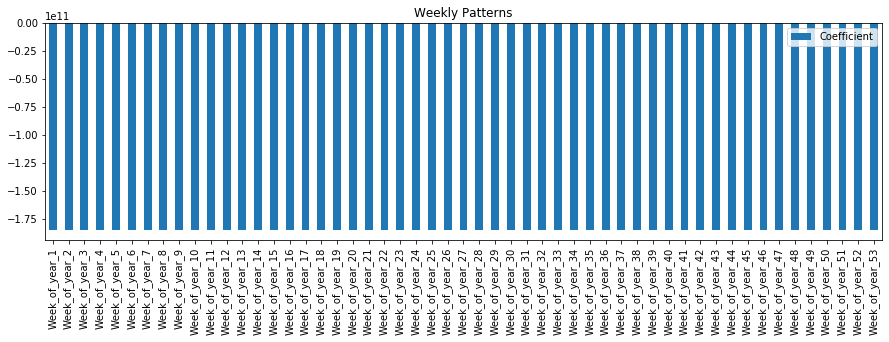

In [21]:
# Plot the results of the individual seasonal effects using pandas df.plot()
# YOUR CODE HERE 
results.plot(kind="bar", figsize=(15, 4), title= "Weekly Patterns")

 # Return Forecasting: Autocorrelation and the ARMA Model

 Using futures Settle *Returns*, estimated an ARMA model.
 1. Set the AR and MA ("p" and "q") parameters of p=2 and q=1.
 2. Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30. If, when looking at the correlation graphs, additional lags seem important for predicting returns, increase the number of lags in the ARMA model from (1).
 3. Does increasing the number of "p" or "q" increase the ability of the model? Compare your results between the two models by comparing the Bayseian Information Criterion, or BIC.

In [22]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Create a series using "Settle" price percentage returns, and drop any nan's:
returns = fut[["Settle"]].pct_change().dropna()
returns.rename(columns={'Settle':'returns'}, inplace=True)
# Estimate and ARMA model using statsmodels
# Hint: ARMA(df, order=(p, q)).fit()
autoregressive_count = 2
moving_average_window = 1
model = ARMA(returns.values, order=(2,1))
model

In [23]:
returns.head()

,returns
Date,
2014-02-19,-0.000204604
2014-02-20,0.000204645
2014-02-21,-0.002046036
2014-02-24,0.000205023
2014-02-25,0.003279697


In [24]:
results = model.fit()

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1408
Model:                     ARMA(2, 1)   Log Likelihood                5339.302
Method:                       css-mle   S.D. of innovations              0.005
Date:                Tue, 15 Oct 2019   AIC                         -10668.603
Time:                        08:56:07   BIC                         -10642.354
Sample:                             0   HQIC                        -10658.793
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.598e-05      0.000     -0.105      0.917      -0.000       0.000
ar.L1.y        0.2998      0.342      0.877      0.381      -0.371       0.970
ar.L2.y        0.0460      0.027      1.727      0.084      -0.006       0.098
ma.L1.y       -0.3132      0.342     -0.916      0.360      -0.983       0.357
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4302           +0.0000j            2.4302            0.0000
AR.2           -8.9538           +0.0000j            8.9538            0.5000
MA.1            3.1929           +0.0000j            3.1929            0.0000
-----------------------------------------------------------------------------
"""

In [26]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [27]:
# Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30.

#fut.Settle.autocorr(lag=30)
returns.returns.autocorr(lag=1)

-0.013331249481458732

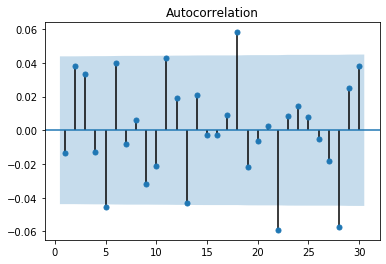

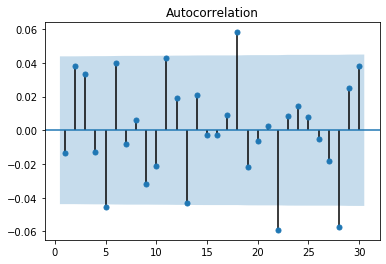

In [28]:
# Autocorrelation (For detecting # of MA ("P") Lags)
#plot_acf(fut.Settle, alpha=0.10)
plot_acf(returns.returns, lags=30, alpha=0.10, zero=False)

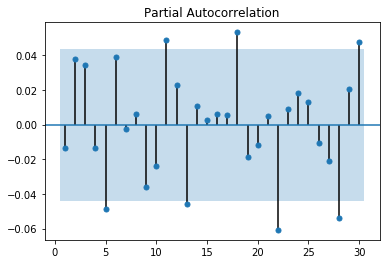

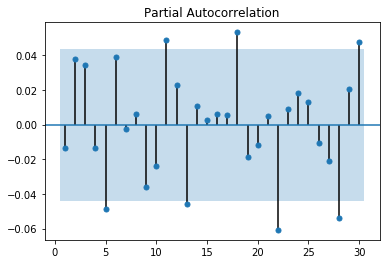

In [29]:
# Partial Autocorrelation (For detecting # of MA ("P") Lags)
#sm.graphics.tsaplots.plot_pacf(fut.Settle, lags=30, zero=False)
sm.graphics.tsaplots.plot_pacf(returns.returns, lags=30, zero=False, alpha=0.10)

In [30]:
autoregressive_count = 17
moving_average_window = 6

# Esimate your model based on your interpretation of the autocorrelation/partial autocorrelation plots:
model = sm.tsa(df, order=(autoregressive_count, moving_average_window)).fit()

# Review model summary results:
model.summary

TypeError: 'module' object is not callable

 # Return Forecasting: Deploying the ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

 2. Plot the residuals from the model. If residuals are the part of returns that our model *doesn"t* explain, does it seem like our model has missed any seasonality?
 3. Construct a 15 day (3 week) forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [31]:
# For ARIMA, construct a dataframe using just the futures "Settle" prices:
df = fut['Settle]'# YOUR CODE HERE 
df

SyntaxError: invalid syntax (<ipython-input-31-ae060d48d1d0>, line 3)

In [32]:
from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df, order=(5, 1, 1))
model_fit = model.fit(disp=0) 
# Output model summary results:
print(model_fit.summary())
# plot residual errors:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Noise (Model Residuals)")
plt.show()
print(residuals.describe())

ValueError: endog must be 1-d or 2-d with 1 column

In [ ]:
# Construct a 15 day (3 week) forecast for the Settle Price. 
# What does the model forecast will happen to the Japanese Yen in the near term?
# Specifically, construct a pandas DataFrame containing ARIMA model forecasts for a 15-day window:


 # Volatility Forecasting

 Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

### Volatility Forecasting: GARCH and EGARCH Models
Using the "arch" package, estimate either GARCH(1,1) or an EGARCH(p,q) volatility forecast model on futures settle returns.

In [ ]:
import arch as arch

In [ ]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by *100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=(fut[["Settle"]].pct_change()*100)
returns=returns.replace(-np.inf, np.nan).dropna()
returns.tail()

In [ ]:
# Estimate a GARCH(1,1) model using the "arch" package:
# (We need to drop all NaN"s first in order to get this to run):
am = # YOUR CODE HERE 
res = am.fit(# YOUR CODE HERE)

In [ ]:
# Output the summary results of the GARCH model:
print(res.summary())

### Volatility Forecasting: Identifying Patterns of Clustered Volatility

GARCH/EGARCH, etc. models are good for capturing the "volatility clustering" effect that is common in financial data. After estimating your model, can you identify periods when volatility clusters together?

In [ ]:
# Plot the model"s conditional volatility for the Yen:
# Hint: use .plot(annualize="D")
fig = # YOUR CODE HERE 

### Volatility Forecasting: 3-day Yen Volatility Forecasts using GARCH/EGARCH
  * Let's do some forecasting of near-term risk. Specifically, use the .forecast() method to calculate 3-day forecasts. Then plot the resulting 3-day annualized variance. Is Yen volatility expected to rise or fall in the near term?

In [ ]:
# Note--You can either specify today"s date manually, or use pd.datetime.today().strftime("%Y-%m-%d") 
# (example format: start="2019-06-28")
# If you have problems with datetime, 
# specify data date manually using the most recent trading date in the dataframe
todays_date = pd.datetime.today().strftime("%Y-%m-%d")                  
# todays_date = '2019-07-05'
# Forecast volatility, from today"s date until the following three days:
forecast_horizon = # YOUR CODE HERE 
forecasts = # YOUR CODE HERE 
forecasts

In [ ]:
# Plot the annualized volatility forecast using pd.plot():
# (Make sure to use dropna() on the forecasts before plotting):
# (There are 252 trading days in a year)
# Note: each column in forecasts.variance represents one day ahead: 
plot_title = f"Forecast Volatility over the next {forecast_horizon} days"
model_forecasts = # YOUR CODE HERE 
model_forecasts.dropna().T.plot(title=plot_title) 

In [ ]:
fig = # YOUR CODE HERE 

 # Out-of-Sample Predictions
 So far, you"ve used the full dataset to construct a model. Let's try a more rigorous technique.

### Out-of-Sample Predictions: Slicing the Data into Training and Test Set ("One Shot" Approach)

Using the SKLearn regression model and just lagged returns as the independent variable, start by estimating a model using **training data** from January, 2015 through December 2017.

In [ ]:
# If you haven"t already, create and add "Futures Return" and "Lagged Futures Return" variables to your dataframe:
# Replace inf, -inf with np.nan, then drop any row with at least one np.nan in the dataframe
fut["Futures Return"] = # YOUR CODE HERE 
fut["Lagged Return"] = # YOUR CODE HERE 
fut = fut.replace(-np.inf, np.nan).dropna()
fut[["Futures Return", "Lagged Return"]].head()

In [ ]:
# Using datetime index slicing, create a "training" data dataframe using data from just 2015-01-01 to 2017-12-31
train = # YOUR CODE HERE 
print("Training set covers from ", train.index.min(), " to ", train.index.max())
train.head(2)

In [ ]:
# Using datetime index slicing, create a "test" data dataframe using data from 2018-01-01 through the end of the data
test = # YOUR CODE HERE 
print("Test set covers from ", test.index.min(), " to ", test.index.max())
test.head(2)

  * Then use the model developed on a test set using data from 2018 onward.

In [ ]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = # YOUR CODE HERE 
y_train = # YOUR CODE HERE 
X_test = # YOUR CODE HERE 
y_test = # YOUR CODE HERE 

In [ ]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
# YOUR CODE HERE 

# Score how that model works using only the test data
# YOUR CODE HERE 

# And make a prediction of "y" values for just the test dataset
predictions = # YOUR CODE HERE 

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [ ]:
Results.head()


  * Compare the RMSE from the model using the test sample to the RMSE when using the full-sample. Are the results surprising?

In [ ]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = # YOUR CODE HERE 

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
one_shot_rmse = # YOUR CODE HERE 
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {one_shot_rmse}")

In [ ]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = # YOUR CODE HERE 

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = # YOUR CODE HERE 

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = # YOUR CODE HERE 
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

### Out-of-Sample Predictions: The Rolling Out-of-Sample Approach

Let's take the model above (i.e., SKLearn predicting futures returns with lagged futures returns), but apply it using a rolling, out of sample approach. This method, which is specific to time-series predictions, will be a more realistic and more rigorous approximation of how the model would perform in real life.

Specifically, start at the beginning of the dataset and "roll forward" one week at a time, using a 26-week (6 month) rolling training window.

In [ ]:
# Main Idea: Each week, re-estimate the model, then trade on it the following week. 
# Continue this "out of sample" approach throughout the dataset.

In [ ]:
# Construct an empty placeholder dataframe, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
# Construct an empty placeholder dataframe, with a column named "Actual Returns"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_actuals = pd.DataFrame(columns=["Actual Returns"])

# construct a list of all pandas weekly periods that are in the dataset:
weeks = fut.index.to_period("w").unique()

# Specify a training window (26 weeks (6 months) of data)
training_window = 26  

# Write a for loop that iterates from 0 to the number of weeks (minus the training window) in the dataset:
# We have to subtract the length of the training window because
# Going beyond this goes beyond the length of our dataset    
for i in range(0, (len(weeks) - training_window - 1)):
# Create an datetime object to mark the beginning of the training window (which changes, for each "i"):     
    beginning_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    start_training_period = # YOUR CODE HERE 
# Create an datetime object to mark the ending of the training window (which would be "i"+training_window_length):  
    ending_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    end_training_period = # YOUR CODE HERE 
# Create a datetime object that marks the week of test-window data:
    test_week = # YOUR CODE HERE 
# Create a string variable from the beginning of that time object with format="%Y-%m-%d"
    start_test_week = # YOUR CODE HERE 
# Create a string variable from the end of that time object with format="%Y-%m-%d"    
    end_test_week = # YOUR CODE HERE 
# Create a dataframe that includes only data during the training window
# (Use datetime slicing and the two start and end string dates constructed above):
    train =  # YOUR CODE HERE 
# Do the same to construct a dataframe including data in the test sample window:    
    test =  # YOUR CODE HERE 
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
    X_train = train["Lagged Return"].to_frame()
    y_train = train["Futures Return"]
    X_test = test["Lagged Return"].to_frame()
    y_test = test["Futures Return"]
# Fit a linear regression to the two training dataframes
    # YOUR CODE HERE 
# Use the model to construct predictions on the X test dataframe,
# and save them as a temporary pandas DataFrame 
    predictions =  # YOUR CODE HERE 
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
# Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
# Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    # Once the loop is done, concatenate (combine) the two dataframes to a final "Results" dataframe:    
    Results =  # YOUR CODE HERE 


In [ ]:
# Plot the results:
# YOUR CODE HERE 

  * Evaluate the model RMSE.
      * Which has the better RMSE--this more robust method, or the single ("one-shot") training and test split just above?

In [ ]:
# Calculate the mean_squared_error on the Results DataFrame:
# (This compares the average (squared) difference between actual and model-predicted returns)
rolling_mse = # YOUR CODE HERE 
# Then use that to calculate the Root-Mean-Squared Error (RMSE):
rolling_rmse = # YOUR CODE HERE 
rolling_rmse

In [ ]:
# Compare the RMSE from the training-testing single split versus the rolling out-of-sample approach we just did:
# YOUR CODE HERE 

Challenge: Can you calculate the out-of-sample R2? Based on this, should we bet money on this model?

In [ ]:
# YOUR CODE HERE 